In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = '/kaggle/input/weapon-detection-vgg-16/weapon_detection'  # Replace with actual dataset path
train_path = 'train'
val_path = 'val'

# Create train and validation directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Split dataset into train and validation sets
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create category directories in train and val folders
    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(val_path, category), exist_ok=True)
    
    # Move images to train folder
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_path, category, img))
    
    # Move images to val folder
    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(val_path, category, img))

print("Dataset has been split into training and validation sets.")


Dataset has been split into training and validation sets.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,  # Correct path for training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,  # Correct path for validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3758 images belonging to 2 classes.
Found 940 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import VGG16
import numpy as np

# Load VGG16 model without the top layers (for feature extraction)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features
def extract_features(generator, num_images):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * generator.batch_size >= num_images:
            break
    features = np.concatenate(features)[:num_images]
    labels = np.concatenate(labels)[:num_images]
    return features, labels

# Extract features for training and validation data
train_features, train_labels = extract_features(train_generator, 3758)
val_features, val_labels = extract_features(val_generator, 940)

# Flatten the features (VGG16 outputs a 4D tensor, we need a 2D tensor for fully connected layers)
train_features_flat = np.reshape(train_features, (3758, 7 * 7 * 512))
val_features_flat = np.reshape(val_features, (940, 7 * 7 * 512))

print("Features extracted and flattened.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [10]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build the fully connected model
input_layer = Input(shape=(7 * 7 * 512,))  # Input shape based on VGG16 output size
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model_top = Model(inputs=input_layer, outputs=output_layer)
model_top.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model_top.fit(
    train_features_flat,
    train_labels,
    epochs=50,
    validation_data=(val_features_flat, val_labels),
    callbacks=[early_stopping]
)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6441 - loss: 0.6518 - val_accuracy: 0.8777 - val_loss: 0.3392
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8420 - loss: 0.3799 - val_accuracy: 0.9117 - val_loss: 0.2449
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8892 - loss: 0.2812 - val_accuracy: 0.9277 - val_loss: 0.2037
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9092 - loss: 0.2463 - val_accuracy: 0.9298 - val_loss: 0.1861
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9206 - loss: 0.2097 - val_accuracy: 0.9394 - val_loss: 0.1790
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9241 - loss: 0.1928 - val_accuracy: 0.9404 - val_loss: 0.1636
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9309 - loss: 0.1870 - val_accuracy: 0.9372 - val_loss: 0.1569
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9324 - loss: 0.1683 - val_accuracy: 0

In [11]:
# Save the trained model
model_top.save('model_top.h5')  # Save the model to a file

In [14]:
from tensorflow.keras.models import load_model

# Load the model from file
model_top = load_model('/kaggle/working/model_top.h5')  # Replace with actual model path


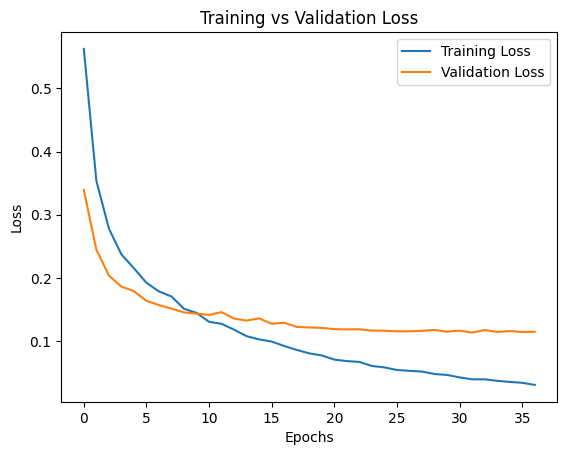

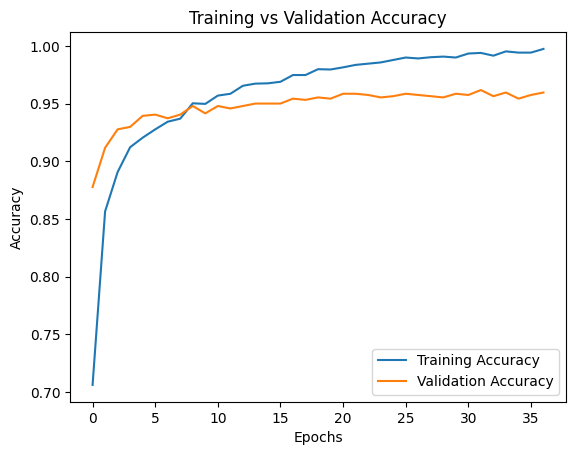

In [15]:
import matplotlib.pyplot as plt

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

# Predict the labels for validation data
val_predictions = model_top.predict(val_features_flat)

# Convert predictions and true labels to one-hot encoded format
val_predictions_classes = val_predictions.argmax(axis=1)
val_true_classes = val_labels.argmax(axis=1)

# Calculate accuracy, F1-score, and precision
accuracy = accuracy_score(val_true_classes, val_predictions_classes)
f1 = f1_score(val_true_classes, val_predictions_classes, average='weighted')
precision = precision_score(val_true_classes, val_predictions_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.9617021276595744
F1-score: 0.9617021276595744
Precision: 0.9617021276595744


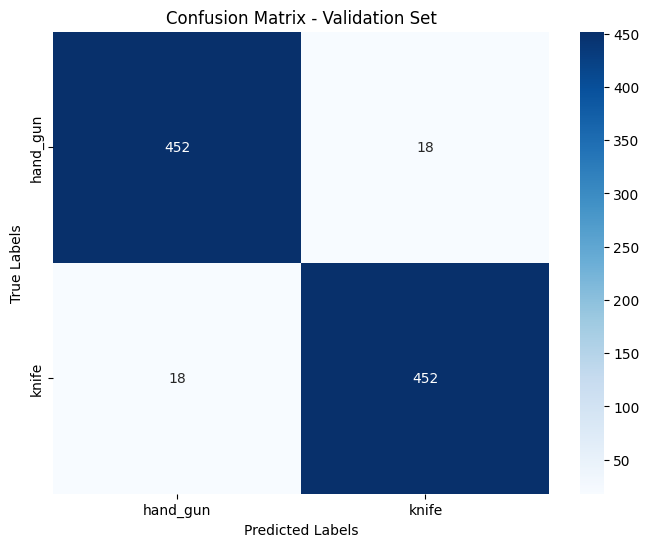

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `val_true_classes` and `val_predictions_classes` are already defined

# Confusion matrix for validation set
cm_val = confusion_matrix(val_true_classes, val_predictions_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

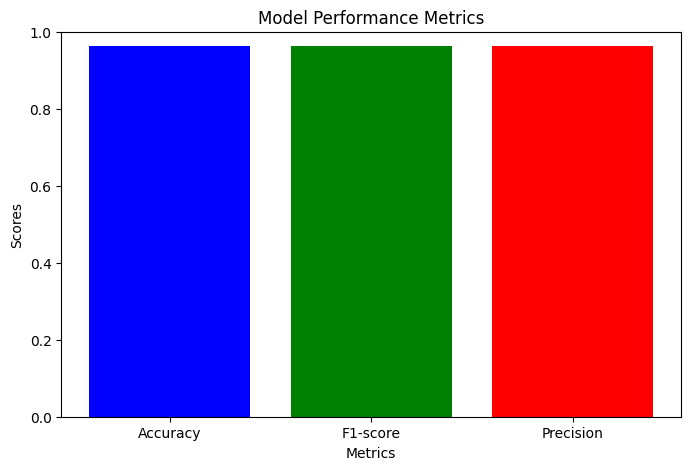

In [18]:
import matplotlib.pyplot as plt

# Assuming `accuracy`, `f1`, and `precision` are already calculated

# Define the scores
scores = [accuracy, f1, precision]
score_names = ['Accuracy', 'F1-score', 'Precision']

# Plot the scores
plt.figure(figsize=(8, 5))
plt.bar(score_names, scores, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.show()


In [19]:
import numpy as np

# Covariance matrix for training features
cov_matrix = np.cov(train_features_flat.T)
print("Covariance Matrix:\n", cov_matrix)

Covariance Matrix:
 [[ 1.52352942e-01  0.00000000e+00  1.49055250e-03 ... -4.00825273e-04
   4.75363886e-03  1.75569842e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.49055250e-03  0.00000000e+00  8.73511838e-03 ... -7.20757621e-05
   4.01219709e-04 -6.18140693e-07]
 ...
 [-4.00825273e-04  0.00000000e+00 -7.20757621e-05 ...  3.32282858e-03
  -1.03927644e-03  1.53966242e-06]
 [ 4.75363886e-03  0.00000000e+00  4.01219709e-04 ... -1.03927644e-03
   8.42745047e-02  2.81117364e-06]
 [ 1.75569842e-05  0.00000000e+00 -6.18140693e-07 ...  1.53966242e-06
   2.81117364e-06  4.17258350e-06]]


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
import numpy as np

# Load the model (if not already loaded)
model_top = load_model('/kaggle/working/model_top.h5')  # Replace with the actual path to your saved model

# Define the path to the new image
new_image_path = '/kaggle/input/test-dataset/test/DSC_00071_box1.jpg'  # Replace with the actual path to your image

# Preprocess the new image
img = load_img(new_image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale the image

# Extract features using the base model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = base_model.predict(img_array)

# Flatten the features to match the input shape of the fully connected model
features_flat = np.reshape(features, (1, 7 * 7 * 512))

# Predict the class of the new image using the fully connected model
new_prediction = model_top.predict(features_flat)

# Convert prediction to class label
predicted_class = new_prediction.argmax(axis=1)

# Manually define your class labels if you don't have `train_generator.class_indices`
class_labels = ['handgun', 'knife']  # Replace with your actual class labels

# Map the predicted class index to the class label
predicted_label = class_labels[predicted_class[0]]

print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted label: knife


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
import numpy as np

# Load the model (if not already loaded)
model_top = load_model('/kaggle/working/model_top.h5')  # Replace with the actual path to your saved model

# Define the path to the new image
new_image_path = '/kaggle/input/test-dataset/test/pistol_0191_box1.jpg'  # Replace with the actual path to your image

# Preprocess the new image
img = load_img(new_image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale the image

# Extract features using the base model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = base_model.predict(img_array)

# Flatten the features to match the input shape of the fully connected model
features_flat = np.reshape(features, (1, 7 * 7 * 512))

# Predict the class of the new image using the fully connected model
new_prediction = model_top.predict(features_flat)

# Convert prediction to class label
predicted_class = new_prediction.argmax(axis=1)

# Manually define your class labels if you don't have `train_generator.class_indices`
class_labels = ['handgun', 'knife']  # Replace with your actual class labels

# Map the predicted class index to the class label
predicted_label = class_labels[predicted_class[0]]

print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted label: handgun
